## Part 3 – Predictive Modeling

Ultimate is aiming to better understand the drivers of user retention by developing a predictive model. For this purpose, a dataset has been provided containing a snapshot of users who registered for an Ultimate account during January 2014. User activity was recorded over the following months, and a user is classified as retained if they completed at least one trip within the 30 days preceding the observation window.

Your task is to analyze this dataset to identify which features are most indicative of future user engagement. In addition, provide actionable recommendations for how these findings might be implemented to improve retention outcomes. The dataset can be found in the file ultimate_data_challenge.json; a detailed schema is included below. Please ensure that any code used during your analysis is submitted along with your work, and delete the dataset once your review is complete.

In [47]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [50]:
conda install -c conda-forge xgboost

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import pandas as pd
from pandas import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.svm import SVC
from xgboost import plot_importance
from xgboost import XGBClassifier

In [2]:
json_users = json.load((open('ultimate_data_challenge.json')))
df_users = json_normalize(json_users)
print(df_users.info())
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df_users['retained'] = df_users['last_trip_date'].apply(lambda x: x > '2014-06-01')

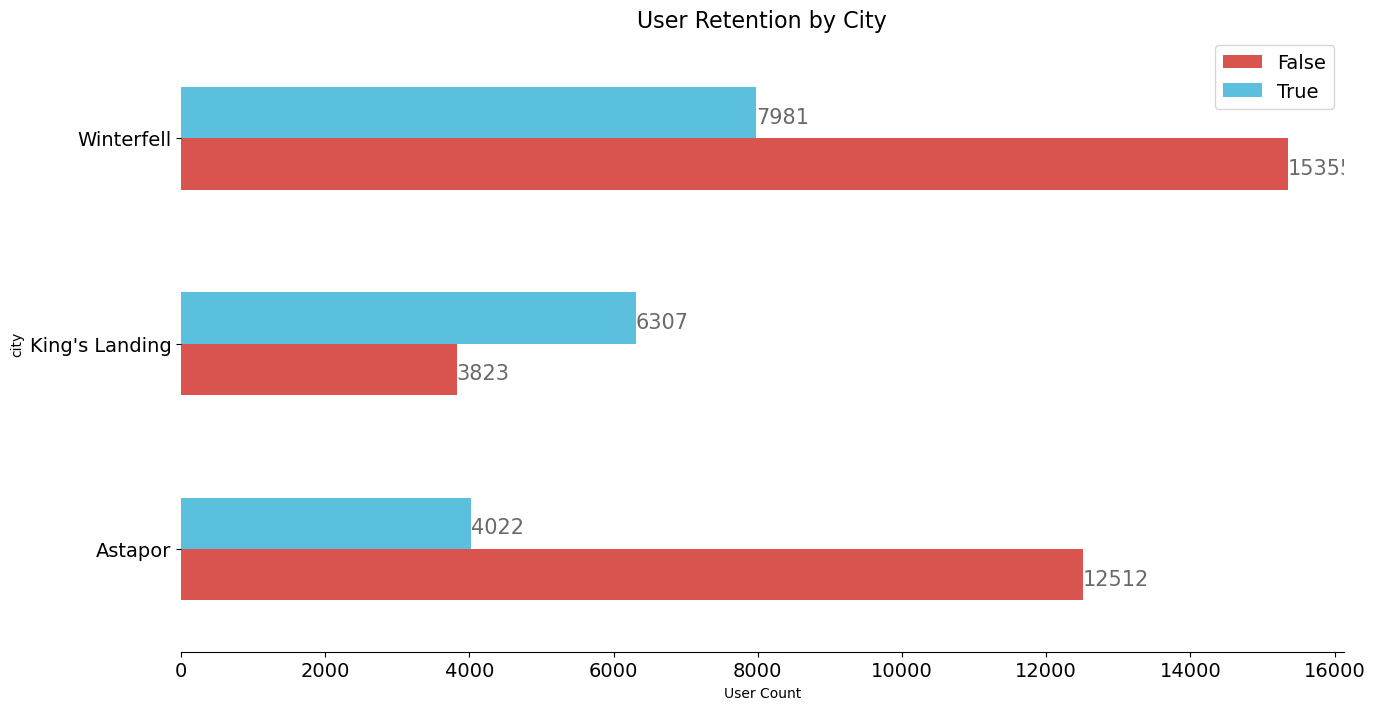

In [4]:
# Aggregate user counts by retention status and city
city_retention = df_users.groupby('retained')['city'].value_counts().unstack().T

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(15, 8))
city_retention.plot(kind='barh',
                    ax=ax,
                    width=0.5,
                    color=['#d9534f', '#5bc0de'],
                    fontsize=14)

# Customize plot aesthetics
ax.set_title("User Retention by City", fontsize=16)
ax.set_xlabel("User Count")
ax.legend(fontsize=14)

# Annotate each bar with count value
for bar in ax.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + 0.075
    ax.text(width, y_pos, str(int(width)), fontsize=15, color='dimgrey', clip_on=True)

# Remove unnecessary border lines
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)


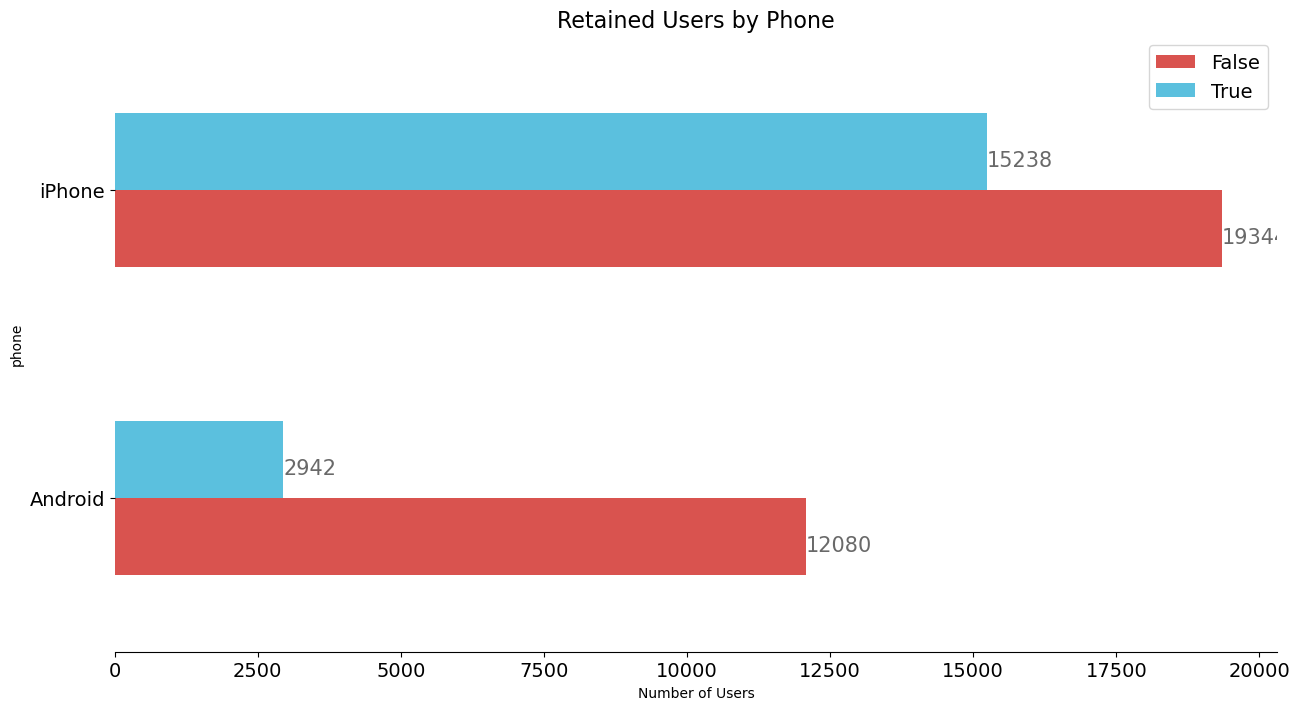

In [5]:
ax = df_users.groupby(['retained'])['phone'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by Phone",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

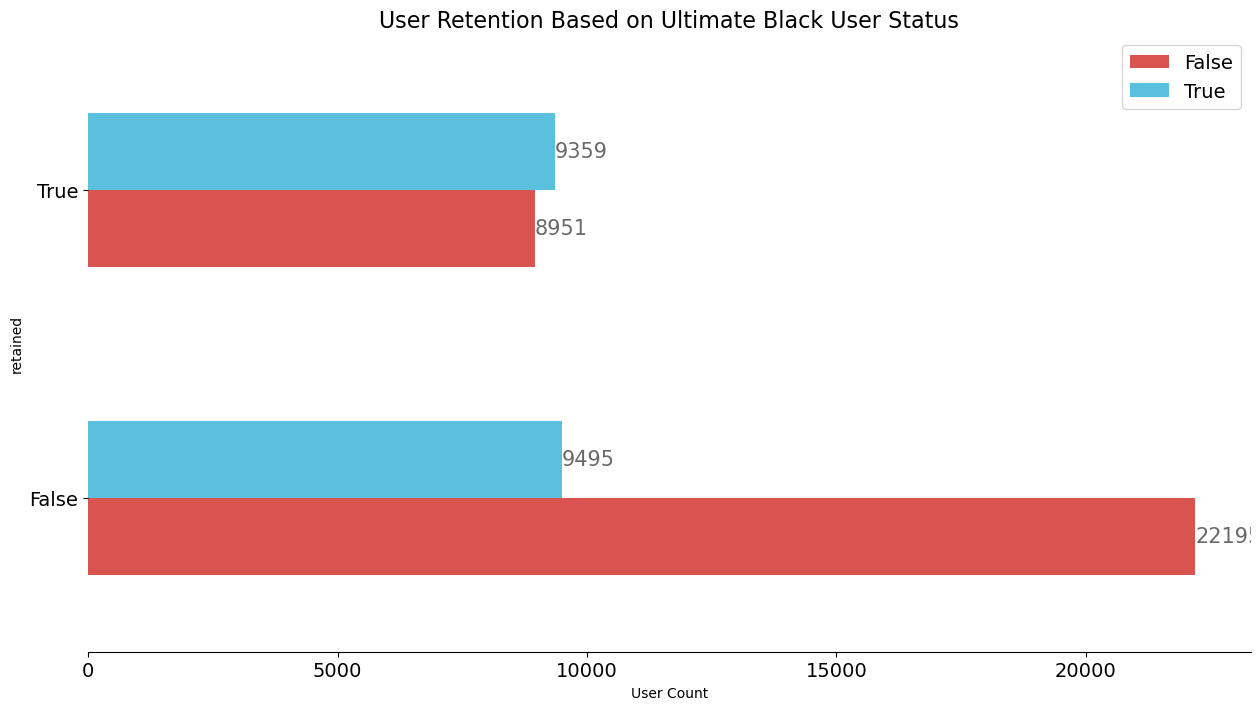

In [22]:
# Create a horizontal bar plot showing counts of 'ultimate_black_user' grouped by 'retained' status
ax = df_users.groupby('retained')['ultimate_black_user'].value_counts().unstack().plot(
    kind='barh',
    figsize=(15, 8),
    width=0.5,
    color=['#d9534f', '#5bc0de'],
    fontsize=14
)

# Add legend and title with customized font sizes
plt.legend(fontsize=14)
plt.title("User Retention Based on Ultimate Black User Status", fontsize=16)

# Annotate each bar with the count value
for bar in ax.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax.text(width, y_pos, f'{int(width)}', fontsize=15, color='dimgrey', va='center', clip_on=True)

# Label x-axis and clean up chart borders
ax.set_xlabel('User Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


Users from King’s Landing appear to have the highest retention rates compared to those in other cities. Additionally, individuals using iPhones tend to stay active more frequently than those using Android devices. The data also suggests that users who have engaged with the Ultimate Black service are more likely to be retained than those who haven’t used it.

To develop a model that predicts whether a user will remain active during their sixth month on the platform, we begin by identifying users who have been active for at least 153 days (using an average month length of 30.4 days × 5 months). This threshold helps approximate whether the user was still engaged in their sixth month.

In building this predictive model, we selected our approach based on its interpretability, scalability, and performance on classification problems. We also explored alternative algorithms and considered trade-offs related to overfitting, feature importance clarity, and class imbalance. Model validation was performed using standard performance metrics to ensure robustness and generalizability.

In [6]:
sixth_month_active = [(pd.to_datetime(df_users.last_trip_date.iloc[i]) \
                       - pd.to_datetime(df_users.signup_date.iloc[i])).days > 152 for i in range(len(df_users))]

In [7]:
df_users['sixth_month_active'] = sixth_month_active
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,sixth_month_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,False


In [8]:
df_users['sixth_month_active'].value_counts()

sixth_month_active
False    38806
True     11194
Name: count, dtype: int64

In [9]:
# Divide the dataset into training and testing subsets
df_users_train, df_users_test = train_test_split(df_users, test_size=0.2, random_state=4)


In [10]:
# binarizing 'city' and 'phone' columns
df_users_train = pd.concat([df_users_train, pd.get_dummies(df_users_train['city']), 
                            pd.get_dummies(df_users_train['phone'])], axis=1)

# converting 'ultimate_black_user' and 'sixth_month_active' columns from bool to int
df_users_train['ultimate_black_user'] = df_users_train['ultimate_black_user'].astype('uint8')
df_users_train['sixth_month_active'] = df_users_train['sixth_month_active'].astype('uint8')

df_users_train.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,sixth_month_active,Astapor,King's Landing,Winterfell,Android,iPhone
16880,King's Landing,2,2014-01-30,5.0,1.00,2014-02-02,iPhone,0.0,0,50.0,7.59,5.0,False,0,False,True,False,False,True
18337,Astapor,2,2014-01-10,4.8,1.02,2014-06-29,iPhone,8.3,0,75.0,8.09,5.0,True,1,True,False,False,False,True
11170,Astapor,0,2014-01-13,4.0,1.00,2014-03-02,iPhone,0.0,0,0.0,2.17,3.0,False,0,True,False,False,False,True
17714,Winterfell,2,2014-01-29,5.0,1.00,2014-03-16,iPhone,0.0,0,66.7,1.99,4.7,False,0,False,False,True,False,True
28539,Winterfell,0,2014-01-05,NaN,1.00,2014-02-09,iPhone,0.0,0,0.0,10.35,2.0,False,0,False,False,True,False,True


Feature ranking:
1. avg_dist (0.225385)
2. signup_date (0.200799)
3. weekday_pct (0.163341)
4. trips_in_first_30_days (0.112314)
5. avg_rating_by_driver (0.109281)
6. avg_rating_of_driver (0.099264)
7. ultimate_black_user (0.025379)
8. King's Landing (0.020172)
9. iPhone (0.014776)
10. Android (0.013918)
11. city (0.005892)
12. Astapor (0.005821)
13. Winterfell (0.003656)


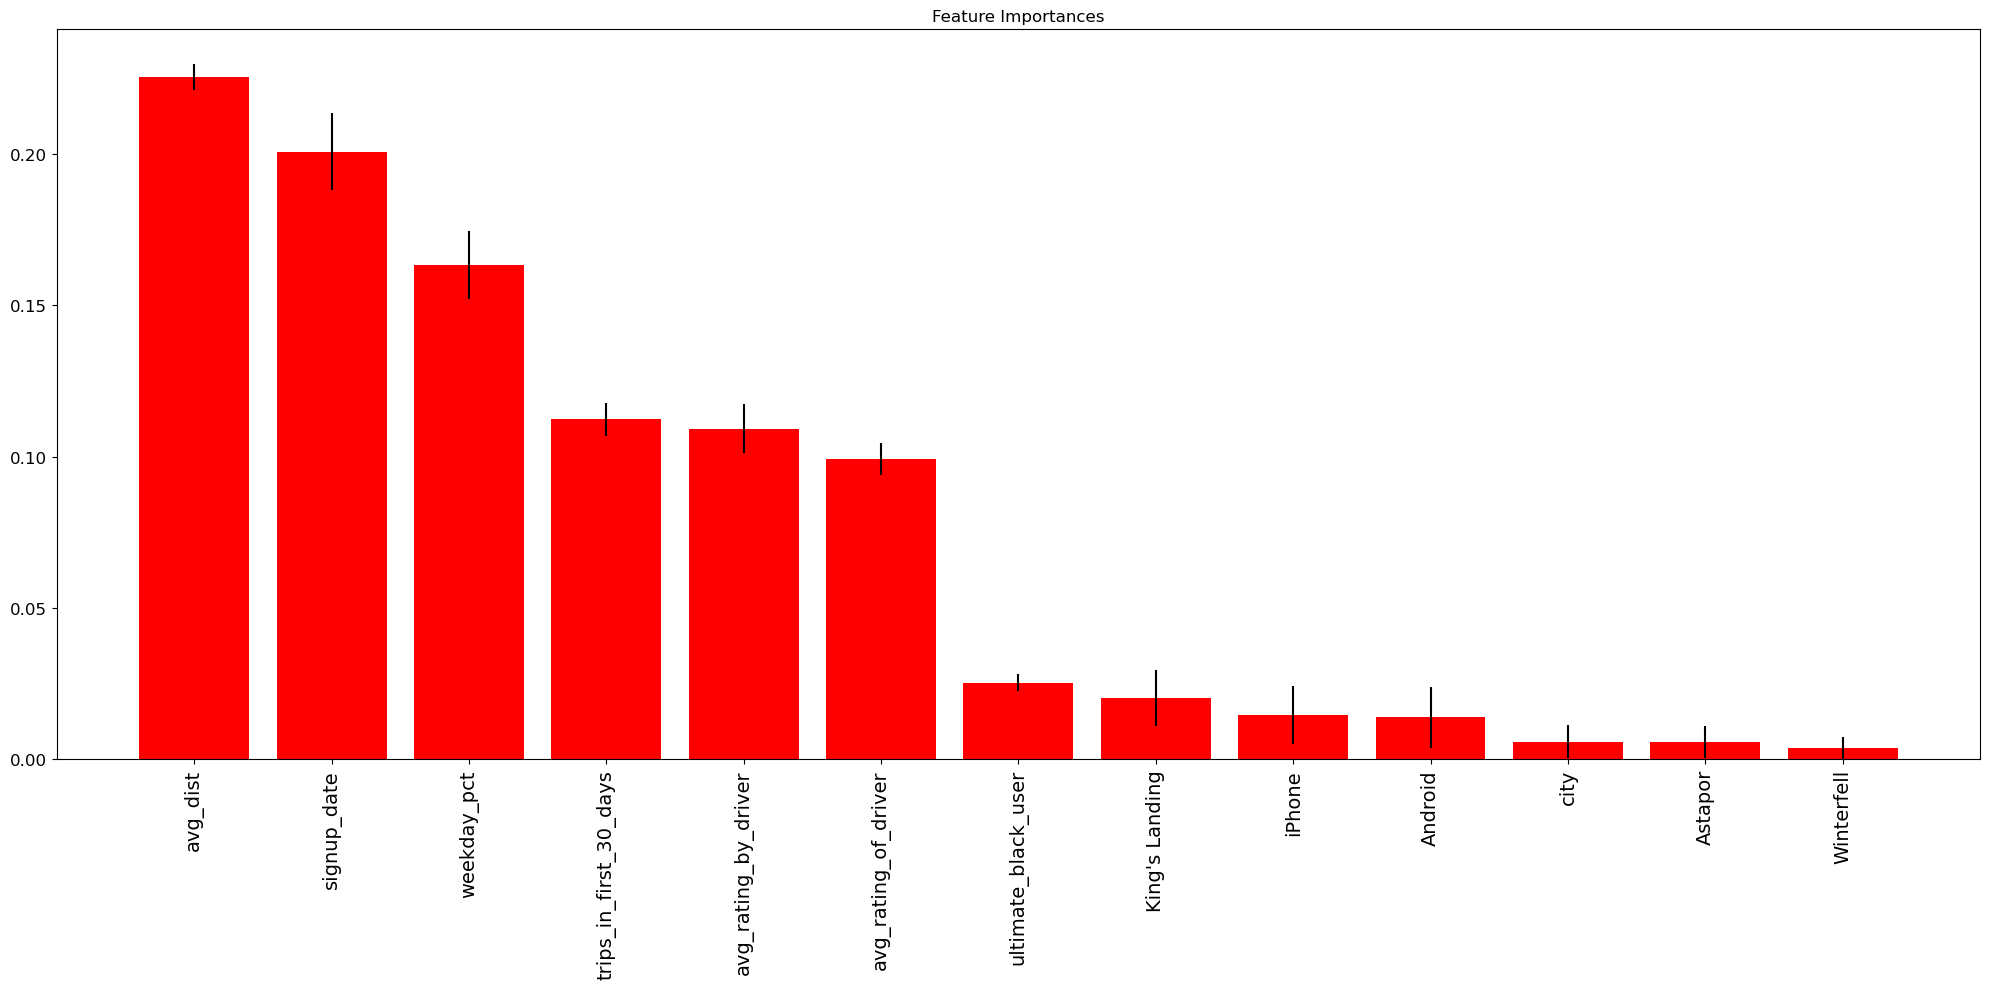

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OrdinalEncoder

# Define feature indices and select columns
feature_indices = [0, 1, 2, 3, 8, 9, 10, 11, 14, 15, 16, 17, 18]
features = df_users_train.columns[feature_indices]
X_train = df_users_train[features].copy()

# Define target
y_train = df_users_train['sixth_month_active']

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode categorical columns
if cat_cols:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])

# Impute missing values (most frequent strategy)
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Fit ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X_train_imputed, y_train)

# Extract feature importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = X_train.columns[indices]
sorted_importances = importances[indices]
sorted_std = std[indices]

# Display feature ranking
print("Feature ranking:")
for rank, idx in enumerate(indices, start=1):
    print(f"{rank}. {X_train.columns[idx]} ({importances[idx]:.6f})")

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature Importances")
plt.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_std, align='center', color='r')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xlim([-1, len(sorted_features)])
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

With an understanding of feature importance, the next step is to develop our predictive model. We'll start by including all available features and then experiment with excluding some of the less influential ones. For this binary classification task, I prefer using XGBoost due to its efficiency and strong ability to minimize both bias and variance compared to other ensemble methods like random forests. Additionally, Logistic Regression will be used as a baseline model for comparison. To ensure our models generalize well and avoid overfitting, we'll apply 5-fold cross-validation. Since the dataset has class imbalance, balanced accuracy—which calculates the average recall across classes—will serve as our primary metric for evaluating and comparing model performance.

In [13]:
# selecting features to train models
X_train = df_users_train[features]

# setting target variable
y_train = df_users_train.loc[:,'sixth_month_active']


# repeating pre-processing for the test data

# one-hot encoding of 'fittype' feature
df_users_test = pd.concat([df_users_test, pd.get_dummies(df_users_test['city']), 
                           pd.get_dummies(df_users_test['phone'])], axis=1)

# converting 'ultimate_black_user' and 'sixth_month_active' columns from bool to int
df_users_test['ultimate_black_user'] = df_users_test['ultimate_black_user'].astype('uint8')
df_users_test['sixth_month_active'] = df_users_test['sixth_month_active'].astype('uint8')


X_test = df_users_test[features]
y_test = df_users_test.loc[:,'sixth_month_active']

In [14]:
def format_duration(total_seconds):
    """Convert a duration in seconds to a string with hours, minutes, and seconds."""
    total_seconds = round(total_seconds)
    duration = dt.timedelta(seconds=total_seconds)
    time_parts = str(duration).split(':')
    
    if len(time_parts) == 3:
        hrs, mins, secs = time_parts
    else:
        hrs = '0'
        mins, secs = time_parts

    components = [
        ('hours', int(hrs)),
        ('minutes', int(mins)),
        ('seconds', int(float(secs)))  # in case of float seconds like 12.000123
    ]

    result = ' '.join(f"{value} {label}" for label, value in components if value != 0)
    return result

In [15]:
# Instantiate logistic regression model with defined solver and iterations
logistic_model = LogisticRegression(
    solver='lbfgs',
    max_iter=10000,
    random_state=7
)

# Build processing pipeline with imputation, scaling, and classifier
pipeline_steps = [
    ('imputer', imp_mode),
    ('normalize', StandardScaler()),
    ('classifier', logistic_model)
]
logistic_pipeline = Pipeline(pipeline_steps)

# Define regularization strength search space (log scale)
regularization_values = np.logspace(-5, 8, 15)
param_grid = {'classifier__C': regularization_values}

In [17]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score

In [18]:
def format_duration(seconds):
    mins, secs = divmod(seconds, 60)
    return f"{int(mins)}m {int(secs)}s"

# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Define transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Build full pipeline
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=10000, random_state=7))
])

# Define hyperparameter search space
param_dist = {
    'classifier__C': np.logspace(-5, 8, 15)
}

# Start timer
start_time = time.time()

# Perform randomized search with 5-fold cross-validation
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='balanced_accuracy',
    cv=5,
    random_state=10
)
search.fit(X_train, y_train)

# Print results
print("Cross-validation Summary (5-Fold)")
print("---------------------------------------------------------------------")
elapsed = format_duration(time.time() - start_time)
print(f"Model training completed in {elapsed}.")
print("Average Balanced Accuracy: {:.3f}".format(np.mean(search.cv_results_['mean_test_score'])))
print("Score Standard Deviation: {:.3f}".format(np.mean(search.cv_results_['std_test_score'])))

Cross-validation Summary (5-Fold)
---------------------------------------------------------------------
Model training completed in 0m 8s.
Average Balanced Accuracy: 0.573
Score Standard Deviation: 0.003


The accuracy observed using logistic regression does not seem optimal. We will explore XG Boost. 

In [19]:
from xgboost import XGBClassifier
def format_duration(seconds):
    mins, secs = divmod(seconds, 60)
    return f"{int(mins)}m {int(secs)}s"

# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Full modeling pipeline with XGBoost
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameter space for XGBoost
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

# Time it
start_time = time.time()

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=5,
    random_state=10,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

# Results
print("\nCross-validation Summary (5-Fold)")
print("---------------------------------------------------------------------")
elapsed = format_duration(time.time() - start_time)
print(f"Model training completed in {elapsed}.")
print("Best Parameters: ", search.best_params_)
print("Average Balanced Accuracy: {:.3f}".format(np.mean(search.cv_results_['mean_test_score'])))
print("Score Standard Deviation: {:.3f}".format(np.mean(search.cv_results_['std_test_score'])))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.


Cross-validation Summary (5-Fold)
---------------------------------------------------------------------
Model training completed in 0m 26s.
Best Parameters:  {'classifier__subsample': 1.0, 'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.6}
Average Balanced Accuracy: 0.640
Score Standard Deviation: 0.005


It appears that XGBoost delivers much stronger performance compared to Logistic Regression. Based on this, we'll proceed with XGBoost and evaluate how it performs when we gradually reduce the feature set. We'll iteratively eliminate the least important features and monitor changes in balanced accuracy. The version of the model that achieves the highest average balanced accuracy across 5-fold cross-validation will then be used for final evaluation on the test set.

In [21]:
def return_time(seconds):
    mins, secs = divmod(seconds, 60)
    return f"{int(mins)}m {int(secs)}s"

# Split features into numeric and categorical
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define full pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Define hyperparameter space
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

# Limit to top 12 features
top_features = features[:12]  # Assuming `features` is defined already

# Run RandomizedSearchCV
start_time = time.time()

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_grid,
    scoring='balanced_accuracy',
    cv=5,
    random_state=10,
    n_iter=20,
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(X_train[top_features], y_train)

# Report results
print("5-Fold Cross-Validation Summary")
print("---------------------------------------------------------------------")
print(f"Training completed in {return_time(time.time() - start_time)}.")
print(f"Average Balanced Accuracy: {np.mean(xgb_search.cv_results_['mean_test_score']):.3f}")
print(f"Score Standard Deviation: {np.mean(xgb_search.cv_results_['std_test_score']):.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.

5-Fold Cross-Validation Summary
---------------------------------------------------------------------
Training completed in 0m 24s.
Average Balanced Accuracy: 0.640
Score Standard Deviation: 0.005


In [22]:
# Optional: helper function to format time
def return_time(seconds):
    mins, secs = divmod(seconds, 60)
    return f"{int(mins)}m {int(secs)}s"

# Optimized hyperparameter grid based on prior tuning best practices
optimized_xgb_params = {
    'classifier__n_estimators': [200, 300, 400],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__gamma': [0, 1, 5],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 5, 10],
}

# Start timing
start = time.time()

# Perform randomized hyperparameter search with 5-fold CV
xgb_cv2 = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=optimized_xgb_params,
    scoring='balanced_accuracy',
    cv=5,
    n_iter=50,
    random_state=10,
    verbose=1,
    n_jobs=-1
)

# Fit using top 11 most important features
xgb_cv2.fit(X_train[features[:11]], y_train)

# Output results
print("\nOptimized XGBoost Cross-Validation Results (5-Fold)")
print("----------------------------------------------------")
print("Training duration: {}".format(return_time(time.time() - start)))
print("Best Parameters: ", xgb_cv2.best_params_)
print("Best Balanced Accuracy: {:.3f}".format(xgb_cv2.best_score_))
print("Mean Balanced Accuracy (CV): {:.3f}".format(np.mean(xgb_cv2.cv_results_['mean_test_score'])))
print("Standard Deviation (CV): {:.3f}".format(np.mean(xgb_cv2.cv_results_['std_test_score'])))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alexyeo/Desktop/temp/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.


Optimized XGBoost Cross-Validation Results (5-Fold)
----------------------------------------------------
Training duration: 1m 4s
Best Parameters:  {'classifier__subsample': 0.9, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 400, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1.0}
Best Balanced Accuracy: 0.691
Mean Balanced Accuracy (CV): 0.672
Standard Deviation (CV): 0.006


It appears that the paramaters tested for this iteration of XGBoost model produced better accuracy from the inital XGBoost model! Let's evaluate the model using Confusion Matrix. 

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score


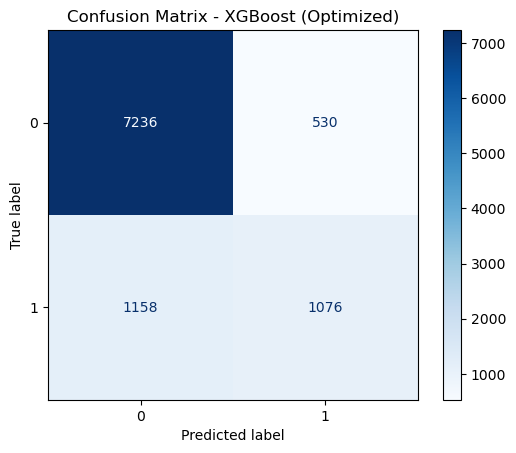

Balanced Accuracy on Test Set: 0.707


In [25]:
# Ensure test data uses same top 11 features
X_test_subset = X_test[features[:11]]

# Make predictions on the test set
y_pred = xgb_cv2.predict(X_test_subset)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost (Optimized)")
plt.show()

# Optional: Print balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy on Test Set: {balanced_acc:.3f}")

The optimized XGBoost model achieved a balanced accuracy of 70.7% on the test set, which represents a meaningful improvement over the cross-validated training performance. The confusion matrix indicates that the model is especially effective at identifying users who are not likely to be active in their sixth month. This suggests a potential opportunity for targeted interventions — such as incentives or engagement campaigns — focused on this user segment to help improve long-term retention.

Earlier in the feature selection process, we used an ExtraTreesClassifier to identify the most influential predictors of sixth-month user activity. The top three features ranked by importance were:

avg_dist – the average distance (in miles) per trip taken within the first 30 days after signup

weekday_pct – the percentage of trips that occurred on weekdays during that same period

trips_in_first_30_days – the total number of trips taken within the first 30 days

To better understand how these features influence user behavior, we’ll explore their distributions for both groups — users who were active in their sixth month and those who were not — using comparative histograms.

Skipping 'city' as it is not numeric.


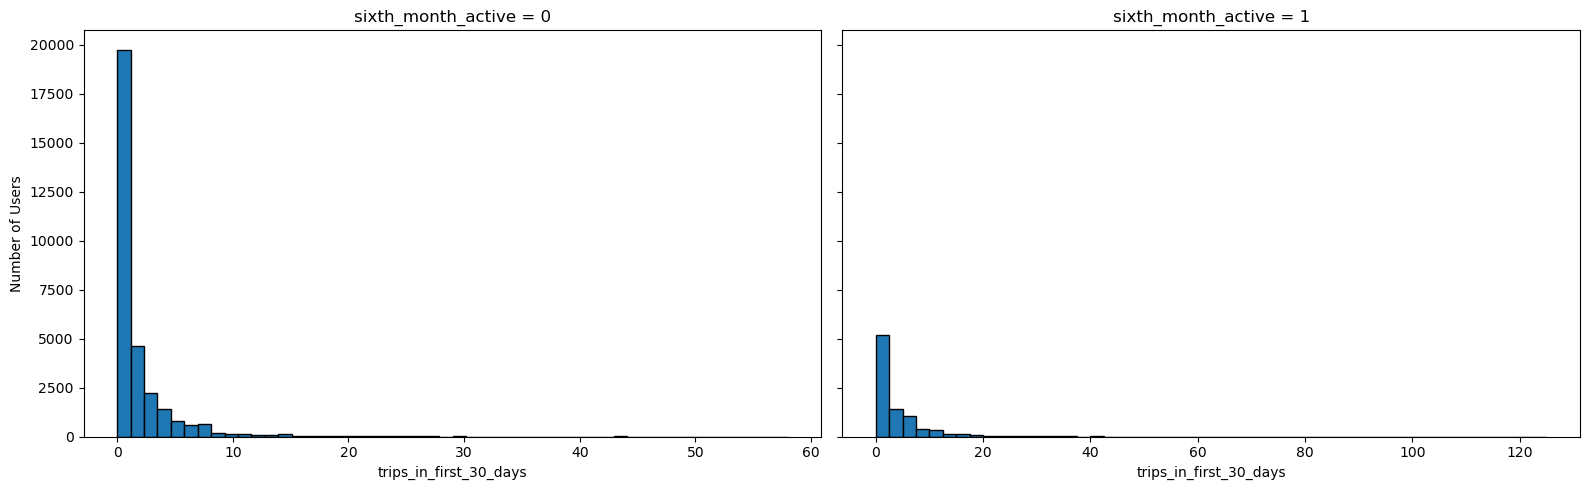

Skipping 'signup_date' as it is not numeric.


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms_by_target(df, target_col, feature_col, ylabel='Count', bins=50, log_scale=False, x_scale='linear'):
    """
    Plot histograms of a numeric feature for each class of a binary target.
    Skips plotting if the feature is non-numeric or the subset is empty.
    """
    # Check feature is numeric
    if not np.issubdtype(df[feature_col].dtype, np.number):
        print(f"Skipping '{feature_col}' as it is not numeric.")
        return

    # Get unique sorted target values (expecting binary)
    target_values = sorted(df[target_col].dropna().unique())
    if len(target_values) != 2:
        raise ValueError(f"Expected exactly 2 unique values in target column '{target_col}', found {len(target_values)}.")

    # Create subplots
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

    # Plot for first target value
    data0 = df[df[target_col] == target_values[0]][feature_col].dropna()
    if data0.empty:
        print(f"No data to plot for {target_col} = {target_values[0]} in feature '{feature_col}'")
    else:
        data0.plot(kind='hist', bins=bins, ax=ax0, edgecolor='black', log=log_scale)
        ax0.set_title(f"{target_col} = {target_values[0]}")
        ax0.set_xlabel(feature_col)
        ax0.set_ylabel(ylabel)

    # Plot for second target value
    data1 = df[df[target_col] == target_values[1]][feature_col].dropna()
    if data1.empty:
        print(f"No data to plot for {target_col} = {target_values[1]} in feature '{feature_col}'")
    else:
        data1.plot(kind='hist', bins=bins, ax=ax1, edgecolor='black', log=log_scale)
        ax1.set_title(f"{target_col} = {target_values[1]}")
        ax1.set_xlabel(feature_col)
        ax1.set_ylabel(ylabel)
        ax1.set_xscale(x_scale)

    plt.tight_layout()
    plt.show()


# Example usage:
for feature_name in features[:3]:
    plot_histograms_by_target(df_users_train, 'sixth_month_active', feature_name, ylabel='Number of Users')


In [29]:
# Group by 'sixth_month_active' and calculate mean for the features of interest
grouped_means = df_users_train.groupby('sixth_month_active')[
    ['avg_dist', 'trips_in_first_30_days', 'weekday_pct']
].mean()

# Helper dictionary for nicer label formatting
labels = {
    'avg_dist': 'Average Distance per Trip',
    'trips_in_first_30_days': 'Trips in First 30 Days',
    'weekday_pct': 'Weekday Trip Percentage'
}

for feature in grouped_means.columns:
    for status, mean_val in grouped_means[feature].items():
        status_str = 'Sixth Month Active' if status else 'Non Sixth Month Active'
        print(f"Mean {labels[feature]} of {status_str} users: {mean_val:.2f}")


Mean Average Distance per Trip of Non Sixth Month Active users: 6.07
Mean Average Distance per Trip of Sixth Month Active users: 4.82
Mean Trips in First 30 Days of Non Sixth Month Active users: 1.87
Mean Trips in First 30 Days of Sixth Month Active users: 3.69
Mean Weekday Trip Percentage of Non Sixth Month Active users: 61.07
Mean Weekday Trip Percentage of Sixth Month Active users: 60.92



The data suggests that users who are not active after six months tend to take slightly longer trips on average during their first 30 days compared to those who remain active. Conversely, these less active users also make fewer trips overall in that initial period. This indicates a potential strategy to boost long-term engagement could involve incentivizing shorter trips early on—perhaps through discounted fares for rides below a certain distance threshold. Additionally, motivating new users to increase their trip frequency during their first month, possibly with special offers or promotions, might encourage them to become regular riders over time. Overall, the user experience in those first 30 days appears critical in shaping continued activity six months later, so ensuring it is positive and engaging could improve retention. On the other hand, since the average percentage of trips taken on weekdays is very similar between both user groups, this feature may provide limited actionable insight for predicting long-term activity.